# Data Assembly and Splitting V1

**Goal:** Assemble the final `model_ready` dataset for YOLOv8 training.

**Strategy: "Sim2Real" with Strict Validation**
To ensure the model learns structure from synthetic data but adapts to the style/noise of real papers, and to prevent it from memorizing synthetic patterns, we use the following split strategy:

1.  **Training Set:** Contains **ALL** synthetic images (learning layout/structure) + **70%** of real images (learning style/noise).
2.  **Validation Set:** Contains **ONLY** real images (15%). This ensures we validate on the target domain (real papers).
3.  **Test Set:** Contains **ONLY** real images (15%) for final evaluation.

**Sources:**
* **Synthetic Data:** `../../dataset/03_intermediate/SCI-3000_synthetic-generated`
    * Images: `images/`
    * Labels: `yolo-labels/` (Note: specific folder name from generator)
* **Real Data:** `../../dataset/03_intermediate/SCI-3000_real-compound`
    * Images: Root or `label-studio_export/`
    * Labels: `label-studio_export/labels/`

In [6]:
import shutil
import random
import os
from pathlib import Path
from tqdm.notebook import tqdm # Notebook-optimierte Progressbar
import yaml
import matplotlib.pyplot as plt

## 1. Configuration & Paths

In [7]:
# --- INPUT PATHS ---
# (Relative to notebook location: src/dev_notebooks)

# 1. Synthetic Data
SYNTH_DIR = Path("../../dataset/03_intermediate/SCI-3000_synthetic-generated")
# Note: Based on your screenshots, synthetic labels are in 'yolo-labels'
SYNTH_IMG_DIR = SYNTH_DIR / "images"
SYNTH_LBL_DIR = SYNTH_DIR / "yolo-labels"

# 2. Real Data
# Adjust these if your images are directly in the root or inside label-studio_export
REAL_BASE_DIR = Path("../../dataset/03_intermediate/SCI-3000_real-compound")
REAL_IMG_DIR = REAL_BASE_DIR
REAL_LBL_DIR = REAL_BASE_DIR / "label-studio_export/labels"

# --- OUTPUT TARGET ---
OUTPUT_DIR = Path("../../dataset/04_model_ready")

# --- SPLIT RATIOS (Real Data Only) ---
VAL_RATIO = 0.15
TEST_RATIO = 0.15
# Remaining 70% goes to Train

# Check paths
print(f"Checking Inputs:")
print(f"  Synth Images: {SYNTH_IMG_DIR.exists()}")
print(f"  Synth Labels: {SYNTH_LBL_DIR.exists()}")
print(f"  Real Labels:  {REAL_LBL_DIR.exists()}")

Checking Inputs:
  Synth Images: True
  Synth Labels: True
  Real Labels:  True


## 2. Helper Functions
Functions to clear directories and safely copy files matching labels to images.

In [10]:
def clear_and_create_dirs(base_path):
    """Clears existing output folder and recreates the structure."""
    if base_path.exists():
        print(f"Cleaning up old directory: {base_path}")
        shutil.rmtree(base_path)
    
    for split in ['train', 'val', 'test']:
        (base_path / "images" / split).mkdir(parents=True, exist_ok=True)
        (base_path / "labels" / split).mkdir(parents=True, exist_ok=True)
    print("Directory structure '04_model_ready' created.")

def find_image(stem, search_dirs):
    """Searches for an image with various extensions in a list of directories."""
    valid_exts = ['.jpg', '.jpeg', '.png', '.JPG', '.PNG']
    for folder in search_dirs:
        if not folder.exists(): continue
        for ext in valid_exts:
            p = folder / (stem + ext)
            if p.exists():
                return p
    return None

def copy_files(file_stems, search_img_dirs, src_lbl_dir, split_type, dataset_name="Real"):
    """
    Copies images and labels to the target split.
    """
    dest_img = OUTPUT_DIR / "images" / split_type
    dest_lbl = OUTPUT_DIR / "labels" / split_type
    
    count = 0
    missing = 0
    
    desc = f"Copying {dataset_name} -> {split_type}"
    
    for stem in tqdm(file_stems, desc=desc):
        # 1. Find Image
        # If search_img_dirs is a single Path, make it a list
        if isinstance(search_img_dirs, Path):
            dirs = [search_img_dirs]
        else:
            dirs = search_img_dirs
            
        img_found = find_image(stem, dirs)
        
        if not img_found:
            missing += 1
            continue
            
        # 2. Find Label
        lbl_found = src_lbl_dir / (stem + ".txt")
            
        if not lbl_found.exists():
            missing += 1
            continue
            
        # 3. Copy
        shutil.copy(img_found, dest_img / img_found.name)
        shutil.copy(lbl_found, dest_lbl / (stem + ".txt"))
        count += 1
        
    return count

## 3. Data Collection & Splitting

In [11]:
# %%
# --- REAL DATA PREPARATION ---
# We iterate over labels because images without labels are useless for training.
real_txts = list(REAL_LBL_DIR.glob("*.txt"))
# Filter out 'classes.txt' if present
real_stems = [f.stem for f in real_txts if f.name != "classes.txt"]

# Shuffle (Crucial for random split!)
random.seed(42) 
random.shuffle(real_stems)

n_total = len(real_stems)
n_test = int(n_total * TEST_RATIO)
n_val = int(n_total * VAL_RATIO)

real_test = real_stems[:n_test]
real_val = real_stems[n_test:n_test+n_val]
real_train = real_stems[n_test+n_val:]

print(f"--- REAL DATA STATS ---")
print(f"Total Labels: {n_total}")
print(f"  Train: {len(real_train)} (~70%)")
print(f"  Val:   {len(real_val)}   (~15%) -> STRICT VALIDATION")
print(f"  Test:  {len(real_test)}  (~15%)")

# --- SYNTHETIC DATA PREPARATION ---
synth_txts = list(SYNTH_LBL_DIR.glob("*.txt"))
synth_stems = [f.stem for f in synth_txts]

print(f"\n--- SYNTHETIC DATA STATS ---")
print(f"Total Labels: {len(synth_stems)}")
print(f"  Train: {len(synth_stems)} (100%)")

--- REAL DATA STATS ---
Total Labels: 704
  Train: 494 (~70%)
  Val:   105   (~15%) -> STRICT VALIDATION
  Test:  105  (~15%)

--- SYNTHETIC DATA STATS ---
Total Labels: 10000
  Train: 10000 (100%)


## 4. Execution: Copy Files
Physically merging files into `04_model_ready`.

In [12]:
clear_and_create_dirs(OUTPUT_DIR)

# 1. Copy Real Data
c_real_train = copy_files(real_train, REAL_IMG_DIR, REAL_LBL_DIR, 'train', "Real")
c_real_val = copy_files(real_val, REAL_IMG_DIR, REAL_LBL_DIR, 'val', "Real")
c_real_test = copy_files(real_test, REAL_IMG_DIR, REAL_LBL_DIR, 'test', "Real")

# 2. Copy Synthetic Data
c_synth = copy_files(synth_stems, SYNTH_IMG_DIR, SYNTH_LBL_DIR, 'train', "Synthetic")

print("\n--- DONE ---")
print(f"Final Train Set: {c_real_train + c_synth} images")
print(f"Final Val Set:   {c_real_val} images")
print(f"Final Test Set:  {c_real_test} images")

Directory structure '04_model_ready' created.


Copying Real -> train:   0%|          | 0/494 [00:00<?, ?it/s]

Copying Real -> val:   0%|          | 0/105 [00:00<?, ?it/s]

Copying Real -> test:   0%|          | 0/105 [00:00<?, ?it/s]

Copying Synthetic -> train:   0%|          | 0/10000 [00:00<?, ?it/s]


--- DONE ---
Final Train Set: 10494 images
Final Val Set:   105 images
Final Test Set:  105 images


## 5. Create YAML Configuration
YOLO requires a `data.yaml` file to know class names and paths.

In [13]:
# Mapping must match your labeling project exactly!
class_names = [
    "Chart",        # 0
    "Illustration", # 1
    "Image",        # 2
    "Other",        # 3
    "Shared Legend",# 4
    "Shared Title", # 5
    "Shared X-Axis",# 6
    "Shared Y-Axis",# 7
    "Subpanel",     # 8
    "Table",        # 9
]

# Using absolute path is safer for YOLO training
abs_path = OUTPUT_DIR.resolve()

yaml_content = {
    'path': str(abs_path),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {i: name for i, name in enumerate(class_names)}
}

yaml_path = OUTPUT_DIR / "data.yaml"
with open(yaml_path, "w") as f:
    yaml.dump(yaml_content, f, sort_keys=False)

print(f"data.yaml created at: {yaml_path}")

data.yaml created at: ../../dataset/04_model_ready/data.yaml


## 6. Visual Sanity Check
Inspecting the source distribution (Real vs. Synthetic) in the final dataset.

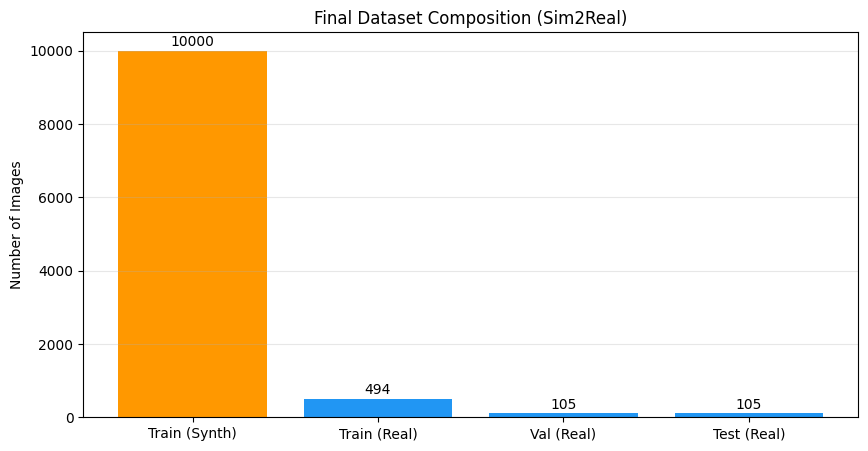

In [14]:
labels = ['Train (Synth)', 'Train (Real)', 'Val (Real)', 'Test (Real)']
values = [c_synth, c_real_train, c_real_val, c_real_test]
colors = ['#FF9800', '#2196F3', '#2196F3', '#2196F3'] # Orange=Synth, Blue=Real

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color=colors)
plt.title('Final Dataset Composition (Sim2Real)')
plt.ylabel('Number of Images')
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, yval, ha='center', va='bottom')

plt.show()

## Check Distribution of classes in real compound training, validation and test data

In [2]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


Lese train: 10494 Dateien gefunden...
Lese val: 105 Dateien gefunden...
Lese test: 105 Dateien gefunden...

=== KLASSEN-VERTEILUNG (Anzahl der Instanzen) ===
               train  val  test  Total
Chart          11122  150   163  11435
Illustration    8678   32    59   8769
Image          14317   70    84  14471
Shared Legend     51   11     8     70
Shared Title      71   14    31    116
Shared X-Axis     78    6    15     99
Shared Y-Axis     63   11    20     94
Subpanel         436   88   119    643
Table           1298    0     6   1304

=== DATEIEN OHNE LABELS (Background Images) ===
train: 0
val: 0
test: 0


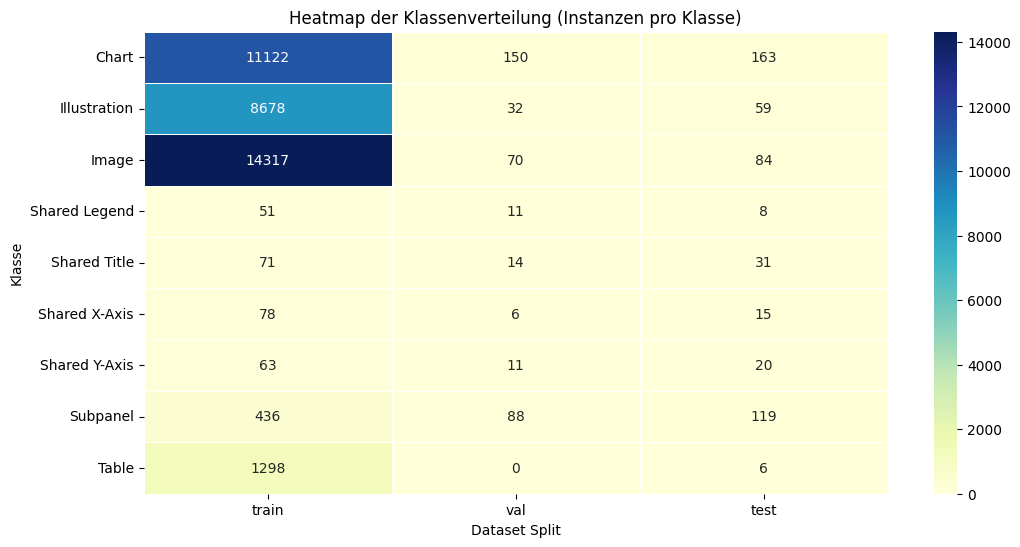

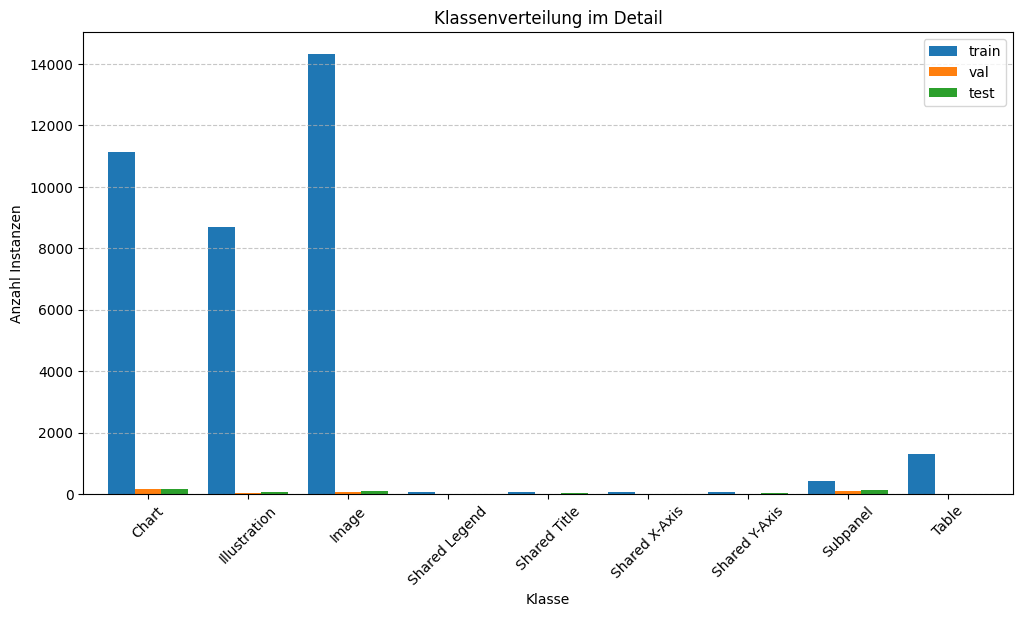

In [4]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# --- KONFIGURATION ---
# Pfad zu deinem Dataset-Ordner (Labels)
base_path = "../../dataset/04_model_ready/labels"

# Deine Klassen-Namen aus der data.yaml
class_names = {
    0: 'Chart',
    1: 'Illustration',
    2: 'Image',
    3: 'Other',
    4: 'Shared Legend',
    5: 'Shared Title',
    6: 'Shared X-Axis',
    7: 'Shared Y-Axis',
    8: 'Subpanel',
    9: 'Table'
}

def get_class_distribution(split_name):
    """Liest alle txt-Files eines Splits und zählt die Klassen-IDs."""
    path = os.path.join(base_path, split_name)
    txt_files = glob.glob(os.path.join(path, "*.txt"))
    
    cnt = Counter()
    files_without_labels = 0
    
    print(f"Lese {split_name}: {len(txt_files)} Dateien gefunden...")
    
    for file_path in txt_files:
        with open(file_path, 'r') as f:
            lines = f.readlines()
            if not lines:
                files_without_labels += 1
            for line in lines:
                try:
                    # Die erste Zahl in jeder Zeile ist die Class ID
                    class_id = int(line.split()[0])
                    cnt[class_id] += 1
                except (ValueError, IndexError):
                    pass # Leere Zeilen oder Fehler ignorieren
                    
    return cnt, files_without_labels

# --- AUSFÜHRUNG ---
stats = {}
empty_files = {}

for split in ['train', 'val', 'test']:
    if os.path.exists(os.path.join(base_path, split)):
        counts, empties = get_class_distribution(split)
        stats[split] = counts
        empty_files[split] = empties
    else:
        print(f"Warnung: Ordner '{split}' existiert nicht.")

# --- DATAFRAME ERSTELLEN ---
df = pd.DataFrame(stats).fillna(0).astype(int)

# Klassen-IDs durch Namen ersetzen (für Lesbarkeit)
df.index = df.index.map(class_names)
df = df.sort_index()

# Gesamtsumme hinzufügen
df['Total'] = df.sum(axis=1)

# --- AUSGABE ---
print("\n=== KLASSEN-VERTEILUNG (Anzahl der Instanzen) ===")
print(df)

print("\n=== DATEIEN OHNE LABELS (Background Images) ===")
for split, count in empty_files.items():
    print(f"{split}: {count}")

# --- VISUALISIERUNG ---
# Plot ohne 'Total' Spalte für bessere Skalierung
plot_df = df.drop(columns=['Total'])

plt.figure(figsize=(12, 6))
sns.heatmap(plot_df, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title("Heatmap der Klassenverteilung (Instanzen pro Klasse)")
plt.ylabel("Klasse")
plt.xlabel("Dataset Split")
plt.show()

# Alternativ: Balkendiagramm (besser für Vergleiche)
plot_df.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title("Klassenverteilung im Detail")
plt.ylabel("Anzahl Instanzen")
plt.xlabel("Klasse")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

This Dataset is very unbalanced, so we will produce a new one, using stratifying and oversampling to improve the performance on the underrepresented classes!

# Data Assembly and Splitting V2: Stratifying and Oversampling

**Goal:** Assemble the final `model_ready` dataset for YOLOv8 training.

**Strategy: "Sim2Real" with Strict Validation**
To ensure the model learns structure from synthetic data but adapts to the style/noise of real papers, and to prevent it from memorizing synthetic patterns, we use the following split strategy:

1.  **Training Set:** Contains **ALL** synthetic images (learning layout/structure) + **70%** of real images (learning style/noise).
2.  **Validation Set:** Contains **ONLY** real images (15%). This ensures we validate on the target domain (real papers).
3.  **Test Set:** Contains **ONLY** real images (15%) for final evaluation.
4.  Now paying attention to keeping better balance of the classes between Train, Validate and Test. 
5.  Doing Oversampling on underrepresented classes.

**Sources:**
* **Synthetic Data:** `../../dataset/03_intermediate/SCI-3000_synthetic-generated`
    * Images: `images/`
    * Labels: `yolo-labels/` (Note: specific folder name from generator)
* **Real Data:** `../../dataset/03_intermediate/SCI-3000_real-compound`
    * Images: Root or `label-studio_export/`
    * Labels: `label-studio_export/labels/`

In [1]:
import shutil
import random
import os
from pathlib import Path
from tqdm.notebook import tqdm # Notebook-optimierte Progressbar
import yaml
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

## 1. Configuration & Paths

In [2]:
# --- INPUT PATHS ---
# (Relative to notebook location: src/dev_notebooks)

# 1. Synthetic Data
SYNTH_DIR = Path("../../dataset/03_intermediate/SCI-3000_synthetic-generated")
# Note: Based on your screenshots, synthetic labels are in 'yolo-labels'
SYNTH_IMG_DIR = SYNTH_DIR / "images"
SYNTH_LBL_DIR = SYNTH_DIR / "yolo-labels"

# 2. Real Data
# Adjust these if your images are directly in the root or inside label-studio_export
REAL_BASE_DIR = Path("../../dataset/03_intermediate/SCI-3000_real-compound")
REAL_IMG_DIR = REAL_BASE_DIR
REAL_LBL_DIR = REAL_BASE_DIR / "label-studio_export/labels"

# --- OUTPUT TARGET ---
OUTPUT_DIR = Path("../../dataset/04_model_ready")

# --- SPLIT RATIOS (Real Data Only) ---
VAL_RATIO = 0.15
TEST_RATIO = 0.15
# Remaining 70% goes to Train

# Check paths
print(f"Checking Inputs:")
print(f"  Synth Images: {SYNTH_IMG_DIR.exists()}")
print(f"  Synth Labels: {SYNTH_LBL_DIR.exists()}")
print(f"  Real Labels:  {REAL_LBL_DIR.exists()}")

# Defining rare classes for oversampling
# 4: Legend, 5: Title, 6: X-Axis, 7: Y-Axis
VERY_RARE_CLASSES = [4, 5, 6, 7] 
RARE_CLASSES = [8]
VERY_OVERSAMPLE_FACTOR = 25
RARE_OVERSAMPLE_FACTOR = 5

Checking Inputs:
  Synth Images: True
  Synth Labels: True
  Real Labels:  True


## 2. Helper Functions
Functions to clear directories and safely copy files matching labels to images.

In [3]:
def clear_and_create_dirs(base_path):
    """Clears existing output folder and recreates the structure."""
    if base_path.exists():
        print(f"Cleaning up old directory: {base_path}")
        shutil.rmtree(base_path)
    
    for split in ['train', 'val', 'test']:
        (base_path / "images" / split).mkdir(parents=True, exist_ok=True)
        (base_path / "labels" / split).mkdir(parents=True, exist_ok=True)
    print("Directory structure '04_model_ready' created.")

def find_image(stem, search_dirs):
    """Searches for an image with various extensions in a list of directories."""
    valid_exts = ['.jpg', '.jpeg', '.png', '.JPG', '.PNG']
    for folder in search_dirs:
        if not folder.exists(): continue
        for ext in valid_exts:
            p = folder / (stem + ext)
            if p.exists():
                return p
    return None

def copy_files(file_stems, search_img_dirs, src_lbl_dir, split_type, dataset_name="Real"):
    """
    Copies images and labels to the target split.
    """
    dest_img = OUTPUT_DIR / "images" / split_type
    dest_lbl = OUTPUT_DIR / "labels" / split_type
    
    count = 0
    missing = 0
    
    desc = f"Copying {dataset_name} -> {split_type}"
    
    for stem in tqdm(file_stems, desc=desc):
        # 1. Find Image
        # If search_img_dirs is a single Path, make it a list
        if isinstance(search_img_dirs, Path):
            dirs = [search_img_dirs]
        else:
            dirs = search_img_dirs
            
        img_found = find_image(stem, dirs)
        
        if not img_found:
            missing += 1
            continue
            
        # 2. Find Label
        lbl_found = src_lbl_dir / (stem + ".txt")
            
        if not lbl_found.exists():
            missing += 1
            continue
            
        # 3. Copy
        shutil.copy(img_found, dest_img / img_found.name)
        shutil.copy(lbl_found, dest_lbl / (stem + ".txt"))
        count += 1
        
    return count


## 3. Data Collection & Splitting

In [4]:
file = "../../dataset/03_intermediate/SCI-3000_real-compound/label-studio_export/real_labels.json"
df = pd.read_json(file)

for idx, row in df.iterrows():
    annotation = row['annotations']
    for result in annotation[0]['result']:
        if result['type'] == 'rectanglelabels':
            if 'Table' in result['value']['rectanglelabels']:
                print(row['data'])


{'image': '/data/local-files/?d=home/tobiasponeschtu/Documents/11818774_CompoundFigureSeparation/dataset/03_intermediate/SCI-3000_real-compound/0d31e54afb194c7d80037e97eafe9167-5-fig-0.png'}
{'image': '/data/local-files/?d=home/tobiasponeschtu/Documents/11818774_CompoundFigureSeparation/dataset/03_intermediate/SCI-3000_real-compound/0d31e54afb194c7d80037e97eafe9167-5-fig-0.png'}
{'image': '/data/local-files/?d=home/tobiasponeschtu/Documents/11818774_CompoundFigureSeparation/dataset/03_intermediate/SCI-3000_real-compound/0d31e54afb194c7d80037e97eafe9167-5-fig-0.png'}
{'image': '/data/local-files/?d=home/tobiasponeschtu/Documents/11818774_CompoundFigureSeparation/dataset/03_intermediate/SCI-3000_real-compound/0d31e54afb194c7d80037e97eafe9167-5-fig-0.png'}
{'image': '/data/local-files/?d=home/tobiasponeschtu/Documents/11818774_CompoundFigureSeparation/dataset/03_intermediate/SCI-3000_real-compound/0d31e54afb194c7d80037e97eafe9167-5-fig-0.png'}
{'image': '/data/local-files/?d=home/tobiaspo

In [12]:
# --- 1. REAL DATA ANALYSE ---
real_txts = list(REAL_LBL_DIR.glob("*.txt"))
data = []

# Definiere Suchpfade für reale Bilder (Basis + Export)
search_img_real = [REAL_IMG_DIR, REAL_BASE_DIR / "label-studio_export"]

print(f"Analysiere {len(real_txts)} reale Label-Dateien...")

for txt_path in tqdm(real_txts, desc="Scanning Labels"):
    if txt_path.name == "classes.txt": continue
    
    with open(txt_path, 'r') as f:
        lines = f.readlines()
        
    classes = []
    for line in lines:
        try:
            classes.append(int(line.split()[0]))
        except: continue
    
    unique_classes = set(classes)
    
    # 1. Spezifischer Check für Table (Klasse 9)
    has_table = 9 in unique_classes
    has_very_rare = any(c in VERY_RARE_CLASSES for c in unique_classes)
    has_rare = any(c in RARE_CLASSES for c in unique_classes)
    
    # 2. Priorisierung anpassen (FIX FÜR VALUE ERROR)
    if has_table:
        # Wir packen das Tabellen-Bild zu "Very Rare" (Gruppe 2),
        # damit der Splitter nicht crasht (wir haben ja nur 1 Bild).
        stratify_group = 2 
        print(f"Found Table in {txt_path.stem}, assigning to stratify group 2 (Very Rare).")
    elif has_very_rare:
        stratify_group = 2
    elif has_rare:
        stratify_group = 1
    else:
        stratify_group = 0
        
    data.append({
        'stem': txt_path.stem,
        'classes': list(unique_classes),
        'stratify_group': stratify_group,
        'has_very_rare': has_very_rare,
        'has_rare': has_rare
    })

df = pd.DataFrame(data)

# Check Verteilung
print("\nVerteilung der Gruppen vor Split:")
print(df['stratify_group'].value_counts().rename({2: 'Very Rare', 1: 'Rare', 0: 'Common'}))

# --- 2. STRATIFIED SPLIT (REAL DATA) ---
train_df, test_val_df = train_test_split(
    df, 
    test_size=(VAL_RATIO + TEST_RATIO), 
    stratify=df['stratify_group'], 
    random_state=42
)

val_df, test_df = train_test_split(
    test_val_df, 
    test_size=0.5, 
    stratify=test_val_df['stratify_group'], 
    random_state=42
)

print(f"\n--- REAL DATA SPLIT ---")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


# --- NEU: SYNTHETIC DATA SPLIT (Table Injection) ---
print("\n--- SYNTHETIC DATA PREP ---")
all_synth_txts = list(SYNTH_LBL_DIR.glob("*.txt"))
synth_tables = []
synth_others = []

# Scanne Synth Data korrekt nach Tabellen (Klasse 9 am Zeilenanfang)
for p in tqdm(all_synth_txts, desc="Scanning Synth Labels"):
    is_table = False
    with open(p, 'r') as f:
        for line in f:
            parts = line.strip().split()
            # Prüfen ob die Zeile nicht leer ist UND das erste Element '9' ist
            if parts and parts[0] == '9':
                is_table = True
                break # Eine Tabelle reicht, um das Bild zu markieren
    
    if is_table:
        synth_tables.append(p.stem)
    else:
        synth_others.append(p.stem)

print(f"Synthetische Tabellen gefunden: {len(synth_tables)}")

# Wir nehmen je 50 Tabellen für Val und Test zur Seite
# (Stelle sicher, dass genug da sind, sonst nimm weniger)
num_to_move = min(50, len(synth_tables) // 3) 
random.shuffle(synth_tables)

synth_val_stems = synth_tables[:num_to_move]
synth_test_stems = synth_tables[num_to_move : num_to_move*2]
synth_train_stems = synth_tables[num_to_move*2:] + synth_others

print(f"Synth Verteilung -> Val: {len(synth_val_stems)}, Test: {len(synth_test_stems)}, Train: {len(synth_train_stems)}")

Analysiere 704 reale Label-Dateien...


Scanning Labels:   0%|          | 0/704 [00:00<?, ?it/s]

Found Table in 0d31e54afb194c7d80037e97eafe9167-5-fig-0, assigning to stratify group 2 (Very Rare).

Verteilung der Gruppen vor Split:
stratify_group
Common       551
Very Rare    146
Rare           7
Name: count, dtype: int64

--- REAL DATA SPLIT ---
Train: 492 | Val: 106 | Test: 106

--- SYNTHETIC DATA PREP ---


Scanning Synth Labels:   0%|          | 0/10000 [00:00<?, ?it/s]

Synthetische Tabellen gefunden: 1213
Synth Verteilung -> Val: 50, Test: 50, Train: 9900


## 4. Execution: Copy Files
Physically merging files into `04_model_ready`.

In [13]:
# --- 3. VERZEICHNISSE & KOPIEREN ---
clear_and_create_dirs(OUTPUT_DIR)

# --- A. OVERSAMPLING LISTE GENERIEREN (Nur Train) ---
train_stems_weighted = []

# Real Data Oversampling
for _, row in train_df.iterrows():
    if row['has_very_rare']:
        train_stems_weighted.extend([row['stem']] * VERY_OVERSAMPLE_FACTOR)
    elif row['has_rare']:
        train_stems_weighted.extend([row['stem']] * RARE_OVERSAMPLE_FACTOR)
    else:
        train_stems_weighted.append(row['stem'])

# Synth Data hinzufügen (nur die für Train!)
train_stems_weighted.extend(synth_train_stems)
random.shuffle(train_stems_weighted)

print(f"Einträge in train.txt (Gesamt): {len(train_stems_weighted)}")


# --- B. PHYSISCHES KOPIEREN ---
def copy_files_and_get_map(unique_stems, src_img_dirs, src_lbl_dir, split_name):
    img_dest = OUTPUT_DIR / "images" / split_name
    lbl_dest = OUTPUT_DIR / "labels" / split_name
    path_map = {}
    
    for stem in tqdm(unique_stems, desc=f"Copying {split_name}"):
        img_path = find_image(stem, src_img_dirs)
        if not img_path: continue
        
        lbl_path = src_lbl_dir / (stem + ".txt")
        if not lbl_path.exists(): continue
        
        shutil.copy(img_path, img_dest / img_path.name)
        shutil.copy(lbl_path, lbl_dest / (stem + ".txt"))
        
        full_path = img_dest.resolve() / img_path.name
        path_map[stem] = str(full_path)
    return path_map

# 1. Real Data Kopieren
map_real_train = copy_files_and_get_map(train_df['stem'].unique(), search_img_real, REAL_LBL_DIR, 'train')
map_real_val   = copy_files_and_get_map(val_df['stem'].unique(), search_img_real, REAL_LBL_DIR, 'val')
map_real_test  = copy_files_and_get_map(test_df['stem'].unique(), search_img_real, REAL_LBL_DIR, 'test')

# 2. Synth Data Kopieren
# Train (Großteil)
map_synth_train = copy_files_and_get_map(synth_train_stems, [SYNTH_IMG_DIR], SYNTH_LBL_DIR, 'train')
# Val (Extra Tabellen)
map_synth_val   = copy_files_and_get_map(synth_val_stems, [SYNTH_IMG_DIR], SYNTH_LBL_DIR, 'val')
# Test (Extra Tabellen)
map_synth_test  = copy_files_and_get_map(synth_test_stems, [SYNTH_IMG_DIR], SYNTH_LBL_DIR, 'test')

# Maps kombinieren
full_train_map = {**map_real_train, **map_synth_train}
full_val_map   = {**map_real_val, **map_synth_val}
full_test_map  = {**map_real_test, **map_synth_test}

# --- C. MANIFEST FILES SCHREIBEN ---
def write_manifest(filename, stem_list, lookup_map):
    out_path = OUTPUT_DIR / filename
    valid_lines = []
    # Wir iterieren über die Liste (wichtig für Oversampling in Train)
    for stem in stem_list:
        if stem in lookup_map:
            valid_lines.append(lookup_map[stem])
            
    with open(out_path, 'w') as f:
        f.write('\n'.join(valid_lines))
    return len(valid_lines)

# Listen für Val/Test müssen wir hier kombinieren (Real + Synth Table Injection)
val_stems_combined = val_df['stem'].tolist() + synth_val_stems
test_stems_combined = test_df['stem'].tolist() + synth_test_stems

n_train = write_manifest('train.txt', train_stems_weighted, full_train_map)
n_val   = write_manifest('val.txt', val_stems_combined, full_val_map)
n_test  = write_manifest('test.txt', test_stems_combined, full_test_map)

print(f"\n--- MANIFEST FILES ERSTELLT ---")
print(f"train.txt: {n_train}")
print(f"val.txt:   {n_val} (davon {len(synth_val_stems)} synth tables)")
print(f"test.txt:  {n_test} (davon {len(synth_test_stems)} synth tables)")

Cleaning up old directory: ../../dataset/04_model_ready
Directory structure '04_model_ready' created.
Einträge in train.txt (Gesamt): 12860


Copying train:   0%|          | 0/492 [00:00<?, ?it/s]

Copying val:   0%|          | 0/106 [00:00<?, ?it/s]

Copying test:   0%|          | 0/106 [00:00<?, ?it/s]

Copying train:   0%|          | 0/9900 [00:00<?, ?it/s]

Copying val:   0%|          | 0/50 [00:00<?, ?it/s]

Copying test:   0%|          | 0/50 [00:00<?, ?it/s]


--- MANIFEST FILES ERSTELLT ---
train.txt: 12860
val.txt:   156 (davon 50 synth tables)
test.txt:  156 (davon 50 synth tables)


## 5. Create YAML Configuration
YOLO requires a `data.yaml` file to know class names and paths.

In [14]:
# --- YAML ERSTELLEN ---
class_names = [
    "Chart", "Illustration", "Image", "Other", 
    "Shared Legend", "Shared Title", "Shared X-Axis", "Shared Y-Axis", 
    "Subpanel", "Table"
]

yaml_content = {
    'path': str(OUTPUT_DIR.resolve()),
    'train': 'train.txt',
    'val': 'val.txt',
    'test': 'test.txt',
    'names': {i: name for i, name in enumerate(class_names)}
}

with open(OUTPUT_DIR / "data.yaml", "w") as f:
    yaml.dump(yaml_content, f, sort_keys=False)

print(f"data.yaml erstellt. Ready for YOLO!")

data.yaml erstellt. Ready for YOLO!


## 6. Visual Sanity Check
Inspecting the source distribution (Real vs. Synthetic) in the final dataset.

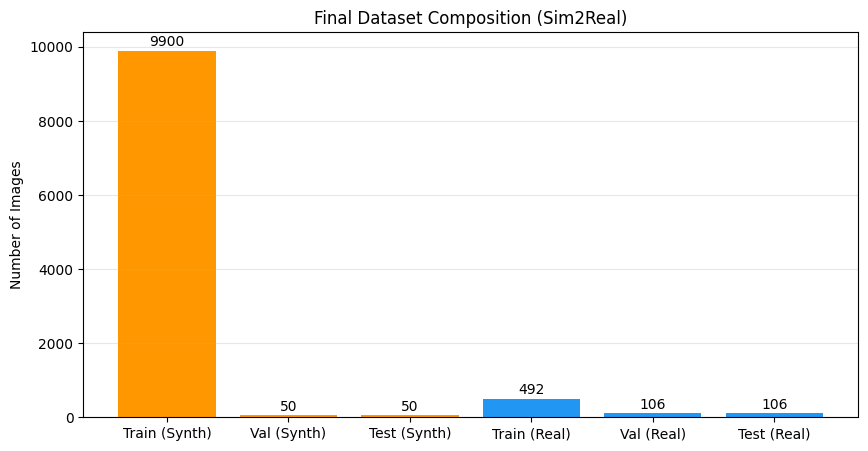

In [15]:
labels = ['Train (Synth)', 'Val (Synth)', 'Test (Synth)', 'Train (Real)', 'Val (Real)', 'Test (Real)']
values = [len(map_synth_train), len(map_synth_val), len(map_synth_test), len(map_real_train), len(map_real_val), len(map_real_test)]
colors = ['#FF9800', '#FF9800', '#FF9800', '#2196F3', '#2196F3', '#2196F3'] # Orange=Synth, Blue=Real

plt.figure(figsize=(10, 5))
bars = plt.bar(labels, values, color=colors)
plt.title('Final Dataset Composition (Sim2Real)')
plt.ylabel('Number of Images')
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, yval, ha='center', va='bottom')

plt.show()

## 7. Check Distribution of classes in real compound training, validation and test data

Analysiere train: 12860 Bilder gelistet...
Analysiere val: 156 Bilder gelistet...
Analysiere test: 156 Bilder gelistet...

=== KLASSEN-VERTEILUNG (Instanzen via .txt File Lists) ===
               train  val  test  Total
Chart          14032  183   208  14423
Illustration    9109  100    88   9297
Image          15088  149   122  15359
Shared Legend   1125   11    14   1150
Shared Title    2250   16    10   2276
Shared X-Axis   1575   18    18   1611
Shared Y-Axis   1675   11    16   1702
Subpanel       10465   95   107  10667
Table           1342   52    54   1448

=== DATEI STATUS ===
TRAIN: Empty Labels (Background): 0 | Missing Label Files: 0
VAL: Empty Labels (Background): 0 | Missing Label Files: 0
TEST: Empty Labels (Background): 0 | Missing Label Files: 0


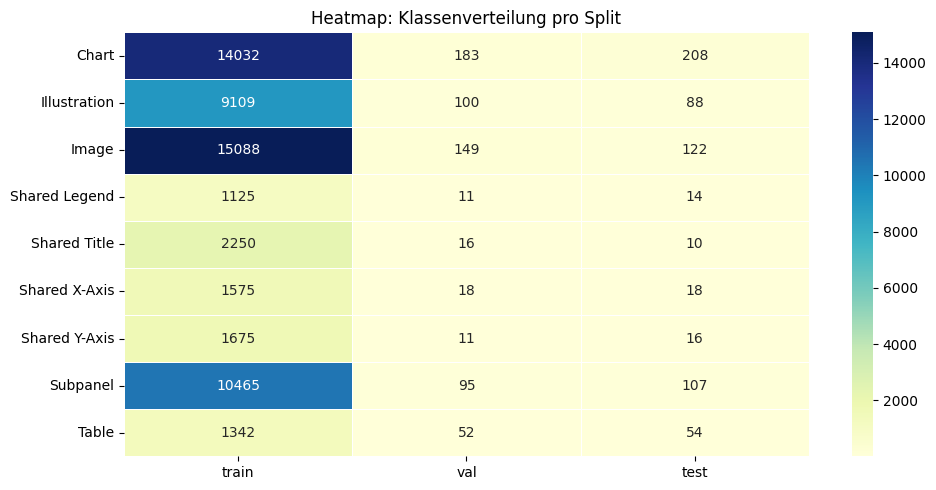

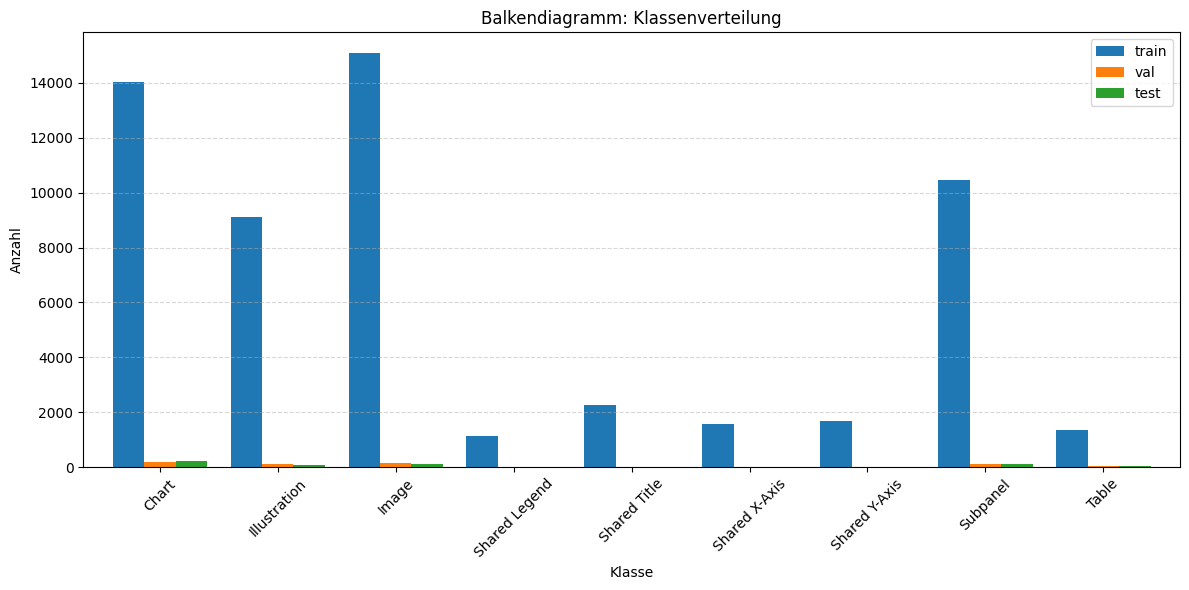

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path

# --- KONFIGURATION ---
# Pfade zu deinen Split-Dateien (.txt files, die Pfade zu Bildern enthalten)
# Passe den Pfad bei Bedarf an, falls die .txt files woanders liegen
base_dir = "../../dataset/04_model_ready"
split_files = {
    'train': os.path.join(base_dir, "train.txt"),
    'val':   os.path.join(base_dir, "val.txt"),
    'test':  os.path.join(base_dir, "test.txt")
}

class_names = {
    0: 'Chart',
    1: 'Illustration',
    2: 'Image',
    3: 'Other',
    4: 'Shared Legend',
    5: 'Shared Title',
    6: 'Shared X-Axis',
    7: 'Shared Y-Axis',
    8: 'Subpanel',
    9: 'Table'
}

def image_path_to_label_path(img_path):
    """
    Wandelt einen Bildpfad in den entsprechenden Labelpfad um.
    Ersetzt '/images/' durch '/labels/' und die Endung durch .txt
    """
    p = Path(img_path)
    # Gehe Ordnerhierarchie hoch, tausche 'images' gegen 'labels'
    # Dies ist eine robuste Methode, die davon ausgeht, dass 'images' im Pfad vorkommt
    parts = list(p.parts)
    try:
        # Finde den Index des Ordners "images" (von rechts suchen ist sicherer)
        idx = len(parts) - 1 - parts[::-1].index("images")
        parts[idx] = "labels"
    except ValueError:
        # Fallback: Falls "images" nicht im Pfad ist (unwahrscheinlich bei YOLO)
        pass
    
    # Pfad neu bauen und Suffix ändern
    new_path = Path(*parts).with_suffix('.txt')
    
    # Falls absolute Pfade in der txt stehen, prüfen wir, ob wir relative brauchen
    # oder ob die Datei direkt existiert. Hier geben wir einfach den Pfad zurück.
    return new_path

def analyze_split_file(split_name, file_path):
    cnt = Counter()
    files_without_labels = 0
    missing_files = 0
    
    if not os.path.exists(file_path):
        print(f"Skipping {split_name}: Datei '{file_path}' nicht gefunden.")
        return cnt, 0, 0

    with open(file_path, 'r') as f:
        img_paths = [line.strip() for line in f.readlines() if line.strip()]

    print(f"Analysiere {split_name}: {len(img_paths)} Bilder gelistet...")

    for img_path in img_paths:
        label_path = image_path_to_label_path(img_path)
        
        # Check ob Label-Datei existiert
        # Hinweis: Je nachdem ob absolute oder relative Pfade in train.txt stehen,
        # muss man hier ggf. den Pfad korrigieren. 
        # Wir probieren es direkt, und falls es relativ ist, hängen wir es an base_dir parent an.
        if not os.path.exists(label_path):
             # Versuch, Pfad relativ zum Dataset-Root aufzulösen falls nötig
             # (Hängt von deinem Setup ab, oft sind Pfade in train.txt absolut)
             if not os.path.exists(label_path):
                 missing_files += 1
                 continue

        with open(label_path, 'r') as f:
            lines = f.readlines()
            if not lines:
                files_without_labels += 1
            for line in lines:
                try:
                    class_id = int(line.split()[0])
                    cnt[class_id] += 1
                except (ValueError, IndexError):
                    pass

    return cnt, files_without_labels, missing_files

# --- AUSFÜHRUNG ---
stats = {}
empty_stats = {}
missing_stats = {}

for split, path in split_files.items():
    counts, empty, missing = analyze_split_file(split, path)
    if counts or empty or missing: # Nur hinzufügen wenn Daten da sind
        stats[split] = counts
        empty_stats[split] = empty
        missing_stats[split] = missing

# --- DATAFRAME ---
if stats:
    df = pd.DataFrame(stats).fillna(0).astype(int)
    df.index = df.index.map(class_names)
    df = df.sort_index()
    df['Total'] = df.sum(axis=1)

    print("\n=== KLASSEN-VERTEILUNG (Instanzen via .txt File Lists) ===")
    print(df)

    print("\n=== DATEI STATUS ===")
    for split in stats.keys():
        print(f"{split.upper()}: Empty Labels (Background): {empty_stats[split]} | Missing Label Files: {missing_stats[split]}")

    # --- VISUALISIERUNG ---
    plot_df = df.drop(columns=['Total'])

    # 1. Heatmap
    plt.figure(figsize=(10, 5))
    sns.heatmap(plot_df, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
    plt.title("Heatmap: Klassenverteilung pro Split")
    plt.tight_layout()
    plt.show()

    # 2. Bar Chart
    plot_df.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.title("Balkendiagramm: Klassenverteilung")
    plt.ylabel("Anzahl")
    plt.xlabel("Klasse")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("Keine Daten gefunden. Prüfe die Pfade in 'split_files'.")